In [30]:
#install.packages("pracma")
#install.packages("EnvStats")
#install.packages("PRROC")
#install.packages("ROCR")

library(pracma)
library(EnvStats)
library(PRROC)
library(ROCR)

In [14]:
set.seed(100)

#establishes gaussian distribution and random sample sizes
gaussian <- function(samples0, samples1, mu0, sigma0, mu1, sigma1) {
    class0 <<- rnorm(samples0, mu0, sigma0) 
    class1 <<- rnorm(samples1, mu1, sigma1)
    return(data.frame(class0, class1))
}

triangle <- function(samples0, samples1, min0, max0, mode0, min1, max1, mode1){
    class0 <<- rtri(samples0, min0, max0, mode0)
    class1 <<- rtri(samples1, min1, max1, mode1)
    return(data.frame(class0, class1))
}

uniform <- function(samples0, samples1, min0, max0, min1, max1){
    class0 <<- runif(samples0, min0, max0)
    class1 <<- runif(samples1, min1, max1)
    return(data.frame(class0, class1))
}

In [3]:
#uses closed formulas to calculate AUC from sigma and mu
formula_gaussian_AUC <- function(mu0, sigma0, mu1, sigma1){
  bound <- (mu1 - mu0)/((sqrt(2))*sqrt((sigma0)^2 + (sigma1)^2))
  func <- function(x) {exp(-x^2)}
  formula_AUC <<- integrate(func, -bound, Inf )$value * (1/sqrt(pi))
}

In [15]:
frame <- function(class0, class1){
    score <- class0
    store_vals0 <- data.frame(score)
    store_vals0$class <- 0

    score <- class1
    store_vals1 <- data.frame(score)
    store_vals1$class <- 1

    store_vals <- rbind(store_vals0, store_vals1)
    store_vals <- store_vals[order(store_vals$score, decreasing=TRUE),]
    store_vals$rank <- c(1:length(store_vals$class))
    store_vals <- store_vals
    return(store_vals)
}

In [16]:
frame2 <- function(class0, class1){
     score <- class0
     store_vals0 <- data.frame(score)
     store_vals0$class <- 0
     
     score <- class1
     store_vals1 <- data.frame(score)
     store_vals1$class <- 1
     
     store_vals <- rbind(store_vals0, store_vals1)
     return(store_vals)
 }

In [17]:
calc_PRC <- function(store_vals){

    rho <- length(store_vals$class[store_vals$class==1]) / length(store_vals$class)
    p <- cumsum(store_vals$class) / (seq(1, length(store_vals$class), 1))
    squared <- (p^2)
    invN <- 1/length(store_vals$class)
    final <- (((invN*sum(squared))/(rho^2)) + 1)*(rho*0.5)

    return(final)
}

In [18]:
calc_AUC <- function(store_vals){
  new_delta_AUC <- 0.5 + ((mean(store_vals$rank[store_vals$class==0]) - mean(store_vals$rank[store_vals$class==1]))/length(store_vals$rank))
  return(new_delta_AUC)
}

In [31]:
#calculates AUPRC and AUPR both the new way and the normal way
calculate_vals <- function(store_vals){

    precision <- NULL
    tp_rate <- NULL
    fp_rate <- NULL
    bac <- NULL

    for (k in 1:length(store_vals$score)){
      sub <- store_vals[1:k,]
      fp <- length(sub$class[sub$class==0])
      tp <- length(sub$class[sub$class==1])
      tn <- length(store_vals$class[store_vals$class==0]) - length(sub$class[sub$class==0])

      prec <- tp / k
      tpr <- tp / length(store_vals$class[store_vals$class==1])
      fpr <- fp / length(store_vals$class[store_vals$class==0])
      spec <- tn / length(store_vals$class[store_vals$class==0])
      balance <- (tpr + spec)/2
        
      precision <- append(precision, prec)
      tp_rate <- append(tp_rate, tpr)
      fp_rate <- append(fp_rate, fpr)
      bac <- append(bac, balance)
    }

    len <- c(1:length(bac))
    par(mfrow=c(3,2))

    novelAUC <- (bac  * (2/length(bac))) - (0.5/length(bac))
    #sum(novelAUC) is AUC actual
    precision2 <- precision^2
    #this sum/integral is directly AUPRC according to our new method
    novelPRC <- (precision2 * (1/(2*length(store_vals$class[store_vals$class==1]))) ) + ((length(store_vals$class[store_vals$class==1])) / (2*(length(store_vals$class)^2)  ))

    plot(len, bac, xlim=range(len), cex=0.1,ylim=range(bac), xlab="threshold (k)", ylab="bac(k)", main="AUC", cex.main=1)
    plot(len, precision2, xlim=range(len), cex=0.1,ylim=range(precision2), xlab="threshold (k)", ylab="prec(k)^2", main="AUPRC", cex.main=1)

    #this sum/integral is directly AUC according to our new method
    plot(len, novelAUC, xlim=range(len), cex=0.1, ylim=range(novelAUC), xlab="threshold (k)", ylab="modified balance accuracy")
    plot(len, novelPRC, xlim=range(len), cex=0.1, ylim=range(novelPRC), xlab="threshold (k)", ylab="modified precision^2")

    plot(fp_rate, tp_rate, xlim=range(fp_rate), cex=0.1, ylim=range(tp_rate), xlab="FPR", ylab="TPR", )
    plot(tp_rate, precision, xlim=range(tp_rate), cex=0.1, ylim=range(precision), xlab="TPR", ylab="precision")


    normal_AUC <- trapz(fp_rate, tp_rate)
    new_AUC <- ((2/length(store_vals$class))*(sum(bac))) - (1/2)
    new_delta_AUC <- 0.5 + ((mean(store_vals$rank[store_vals$class==0]) - 
                            mean(store_vals$rank[store_vals$class==1]))/length(store_vals$rank))    
    
    normal_AUPRC <- trapz(tp_rate, precision)
    rho <- length(store_vals$class[store_vals$class==1]) / length(store_vals$class)
    new_AUPRC <- ((0.5*rho)*(1 + ((sum(precision^2)) / length(store_vals$class))/(rho^2)))
    
    return(c(normal_AUC, normal_AUPRC, new_AUC, new_delta_AUC, new_AUPRC))
}

$class0
   [1] -1.0384604  1.5872965  4.9832902  2.6540130 -0.3798369 -2.8123522
   [7]  3.6866571  2.0253194 -0.7606159  0.5285020 -3.4311684  5.0374460
  [13]  0.4217453  2.0863821  1.7516916  1.1882854  0.9016724  0.7899742
  [19]  2.1724624 -1.6345359  2.3451080  0.1257604  2.6708737 -2.2964179
  [25] -3.5382888  3.7377556  1.2003058 -0.1532716  2.9942693 -1.4001975
  [31] -3.4304892 -2.8330641 -1.0967144 -0.0765664  2.9727395  1.6912514
  [37] -0.6084576 -1.5497265  0.8405791  0.7636017 -1.7932181 -0.1470149
  [43] -0.9783698  2.0743040  0.7509181 -0.5397954  0.5926739 -1.3991442
  [49] -0.8289001 -0.6774956 -1.2060133  0.8846096  0.5968968 -4.0467868
  [55]  0.1291484 -3.2582967  2.8188042  2.1515226  0.0936411 -0.0652659
  [61]  3.1898453 -0.5730467  0.3114826  0.4874505  0.1091007 -2.9623605
  [67] -0.2843342 -2.7598777  0.0025684  3.2974554 -2.0344409 -0.2175808
  [73] -2.4260777 -0.1328731  2.7556125 -2.5149751 -0.4499746 -2.4630850
  [79] -1.5136965  2.8558714 -0.2938646 -3.2473793 -4.0073671  1.6592091
  [85]  1.0945600 -1.1341323  4.0090111  1.7237269 -1.6800748 -0.7627953
  [91]  2.3409805  0.2190340  1.6671720  0.6833291  2.0485849 -1.5473716
  [97]  2.0670567  1.6280498 -2.9559937  0.2906104  0.2546960 -1.3979329
 [103]  1.4987804  0.0885420  0.8254249 -2.5593255  1.9052030  0.2796480
 [109] -1.4454135 -1.8607387  1.1354147 -1.5692041 -0.9992307 -0.6570651
 [115]  0.9718596 -1.3578169  1.4420991  1.3159244  0.8003258 -2.4043186
 [121] -0.2805765 -0.2911713 -2.3548507  5.9543783 -2.8539953 -1.4259747
 [127]  4.5601015  1.2904229 -3.7263593  1.9247132 -1.2288469  1.1437225
 [133]  0.9619787  0.5171114  0.4926254  2.3184924  0.9171015  3.3832155
 [139]  0.5737230  5.6066965  2.0219211  1.9453433  0.8938532 -4.1565569
 [145]  1.0596091  1.0880127 -3.9700965  0.1525327 -0.0552297  1.2868853
 [151]  0.7979750 -1.1332752 -1.2855216 -2.9438967  0.5142793 -0.5715334
 [157] -3.5297601 -2.4353775  0.5055984 -1.5467256 -2.5243398 -0.8700580
 [163]  1.3991399 -1.1526637 -1.0520805 -0.4705817  0.4667749 -1.2686271
 [169] -1.1835278  1.1591542  1.4627955 -3.6662373 -5.0696071  2.8294959
 [175] -0.0164477  1.5864476 -2.0908822  0.2689832  1.3368407 -1.6618671
 [181] -4.5875363 -0.8590298 -0.6299226  2.3326152 -2.0418511 -0.6567391
 [187] -3.0929757 -0.5223010 -1.8851375 -3.3590235  0.8014689  1.2609574
 [193]  1.3325798 -0.6335041 -0.4492962 -0.6128279  1.2214238  3.1704746
 [199] -0.7849182 -3.4655110  2.8148981 -0.4476244  0.9851057  1.1289579
 [205]  0.3422917  0.5476345 -1.8644103  0.1950237  1.9656100 -1.4867765
 [211] -1.9171973 -1.5772975  1.4233081  1.7842384  1.1235946 -0.8572649
 [217] -1.4583061 -0.3962658 -0.1605277 -0.6727366 -0.7557923  0.9487620
 [223]  2.9567532 -1.9806936 -1.3636152 -2.5644095 -1.4447101 -1.1900597
 [229]  0.3085114 -0.1545124  1.9257581 -1.5604923  1.4563226 -0.8607114
 [235]  3.2861672  1.3227213 -1.9504609  1.1536486  3.3684458  2.4746724
 [241]  1.5878782  2.4486814  3.3268485  2.9284207  0.6136367 -6.4250450
 [247]  1.2329079  0.1432632 -4.9000460 -4.4791789 -0.0639362 -0.3728036
 [253] -6.2445397  0.4098012  0.4127860 -0.1780159 -1.5090316  0.5515068
 [259] -3.2069070  0.7724361  0.1989844  2.2053067  0.9820092 -2.0252442
 [265] -5.3660597  0.6993229 -3.6478642  0.1030149 -0.3718840  0.0761919
 [271]  1.1946221 -2.2522379 -0.7186878  0.4957286  0.6598435 -1.4091052
 [277] -0.5372813  0.5404515 -1.2423515  2.0986936 -0.7600444 -2.9238715
 [283] -2.3845093  2.5161655  1.2914781  1.5046601  2.4329933  1.4762328
 [289]  1.6566031  1.7649173 -2.7602233  0.3423395  1.0966675  1.8183448
 [295]  1.1145133  1.5330644 -0.6275375  2.7765588 -1.4769489 -2.6139488
 [301] -0.5718650 -3.4181056  1.9024106 -0.4979613  0.0092393 -1.3530400
 [307]  1.0714697  0.3472299  1.8450380  0.3889576  1.2065147  3.8564921
 [313]  0.3852299  0.7780406  1.3032589  0.2061884  0.9022868 -0.9540344
 [319]  1.0564593  0.5431969 -0.5567299  3.7683224  1.9880227 -1.6515498
 [325]  3.1084435  1.9571386 -0.0733527 -1.5389055

,score,class,rank
,<dbl>,<dbl>,<int>
13443,3.750,1,1
13289,3.750,1,2
12178,3.750,1,3
17407,3.750,1,4
10692,3.750,1,5
14610,3.749,1,6
18634,3.749,1,7
18904,3.749,1,8
19722,3.749,1,9


[1] 0.7233 0.6807 0.7233 0.7233 0.6852

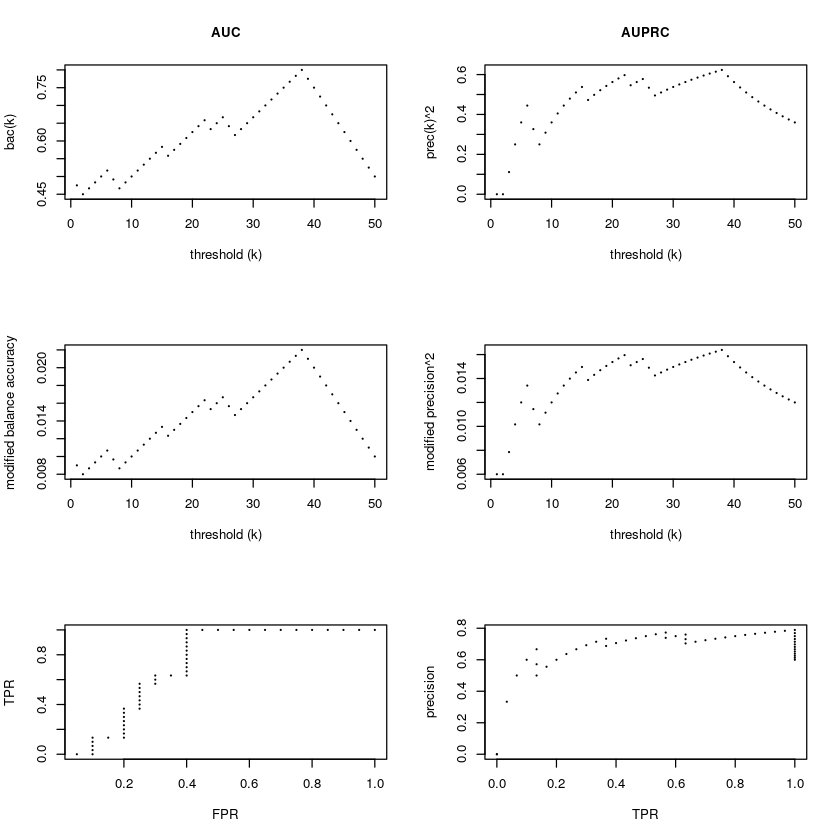

In [32]:
#execution with different gaussian distributions, different sampling sizes
AUC_new <- NULL
PRC_new <- NULL
AUC_normal <- NULL
PRC_normal <- NULL
AUC_formula <- NULL
delta_AUC <- NULL

gaussian(1000,1000,0,2,5,4)
formula_gaussian_AUC(0,2,5,4)
frame(class0, class1)
normal_AUC, normal_AUPRC, new_AUC, new_delta_AUC, new_AUPRC <- calculate_vals(store_vals)

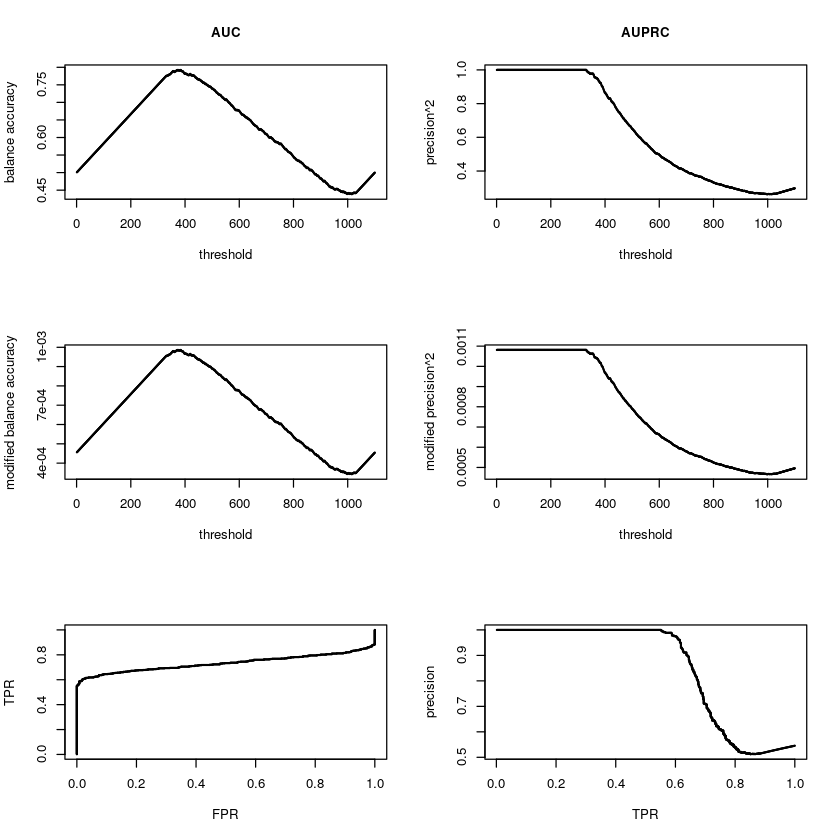

In [7]:
AUC_new <- append(AUC_new, new_AUC)
PRC_new <- append(PRC_new, new_AUPRC)
AUC_normal <- append(AUC_normal,  normal_AUC)
PRC_normal <- append(PRC_normal, normal_AUPRC)
AUC_formula <- append(AUC_formula,  formula_AUC)
delta_AUC <- append(delta_AUC, new_delta_AUC)


gaussian(500,600,6,0.5,8,3)
formula_gaussian_AUC(6,0.5,8,3)
frame(class0, class1)
calculate_vals(store_vals)

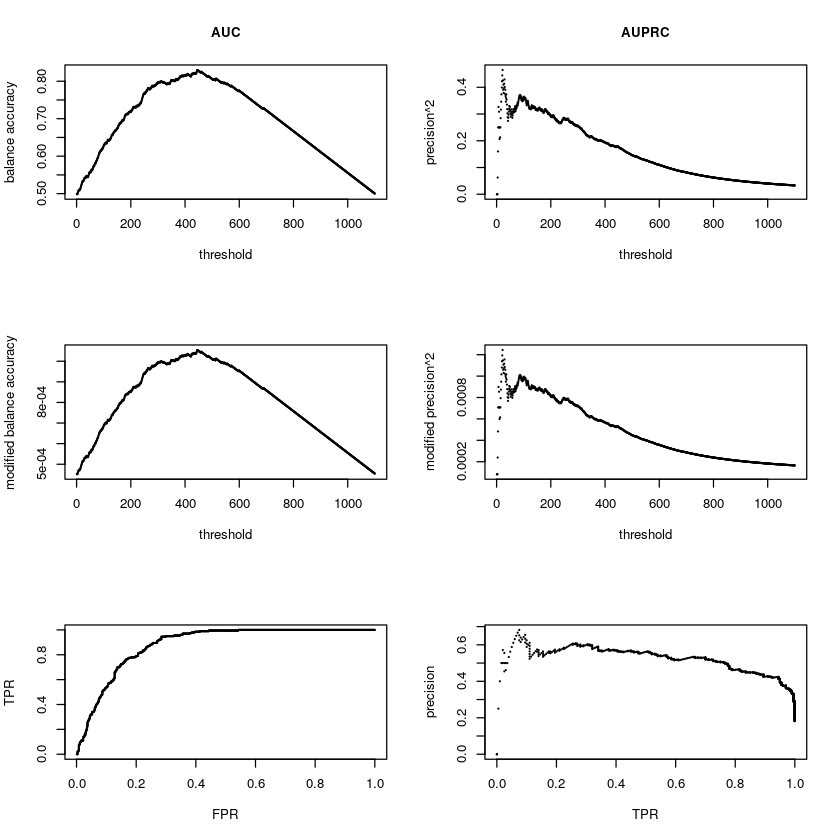

In [8]:
AUC_new <- append(AUC_new, new_AUC)
PRC_new <- append(PRC_new, new_AUPRC)
AUC_normal <- append(AUC_normal,  normal_AUC)
PRC_normal <- append(PRC_normal, normal_AUPRC)
AUC_formula <- append(AUC_formula,  formula_AUC)
delta_AUC <- append(delta_AUC, new_delta_AUC)

gaussian(900,200,3,5,10,3)
formula_gaussian_AUC(3,5,10,3)
frame(class0, class1)
calculate_vals(store_vals)

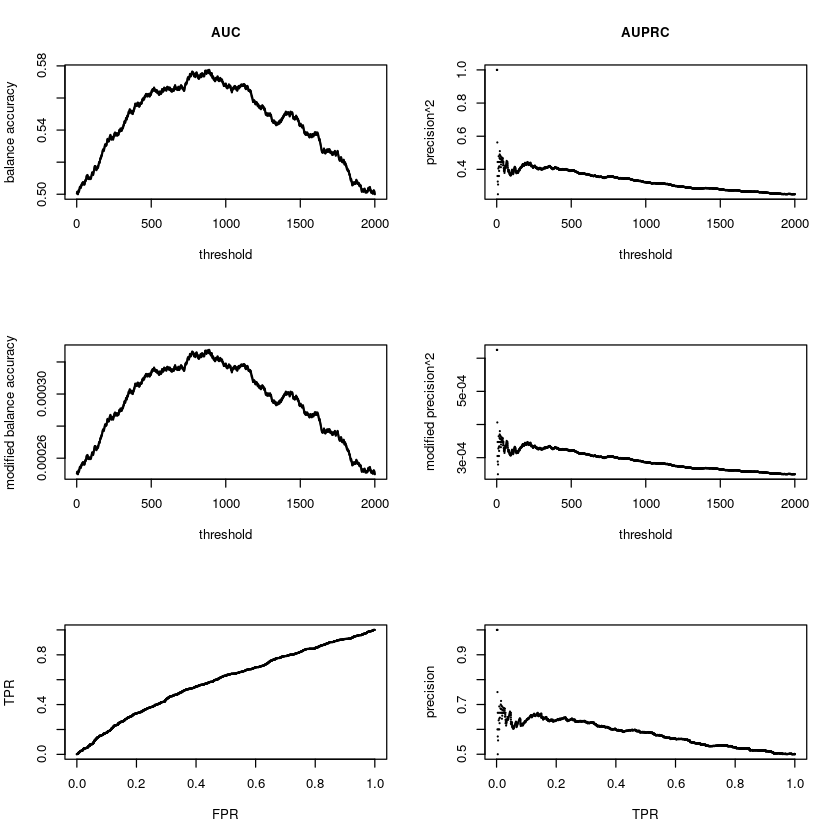

In [9]:
AUC_new <- append(AUC_new, new_AUC)
PRC_new <- append(PRC_new, new_AUPRC)
AUC_normal <- append(AUC_normal,  normal_AUC)
PRC_normal <- append(PRC_normal, normal_AUPRC)
AUC_formula <- append(AUC_formula,  formula_AUC)
delta_AUC <- append(delta_AUC, new_delta_AUC)

#execution with different types of distributions: uniform and triangular

triangle(1000,1000,0,1,0.5,0,1,0.7)
frame(class0, class1)
calculate_vals(store_vals)

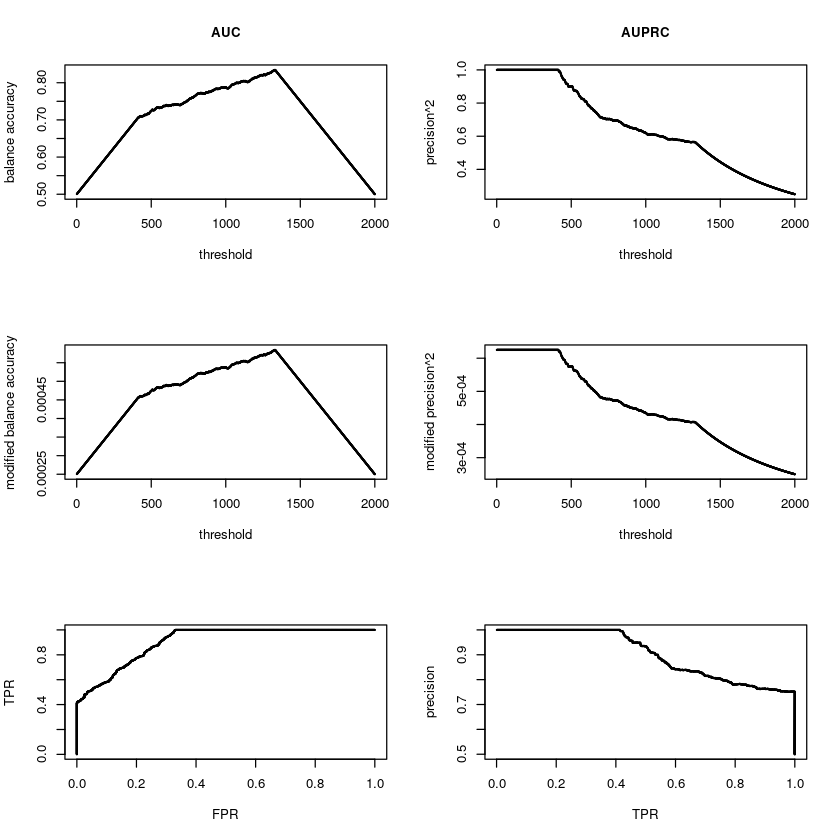

In [10]:
AUC_new <- append(AUC_new, new_AUC)
PRC_new <- append(PRC_new, new_AUPRC)
AUC_normal <- append(AUC_normal,  normal_AUC)
PRC_normal <- append(PRC_normal, normal_AUPRC)
AUC_formula <- append(AUC_formula,  formula_AUC)
delta_AUC <- append(delta_AUC, new_delta_AUC)

uniform(1000,1000,0,3,2,3.75)
frame(class0, class1)
calculate_vals(store_vals)

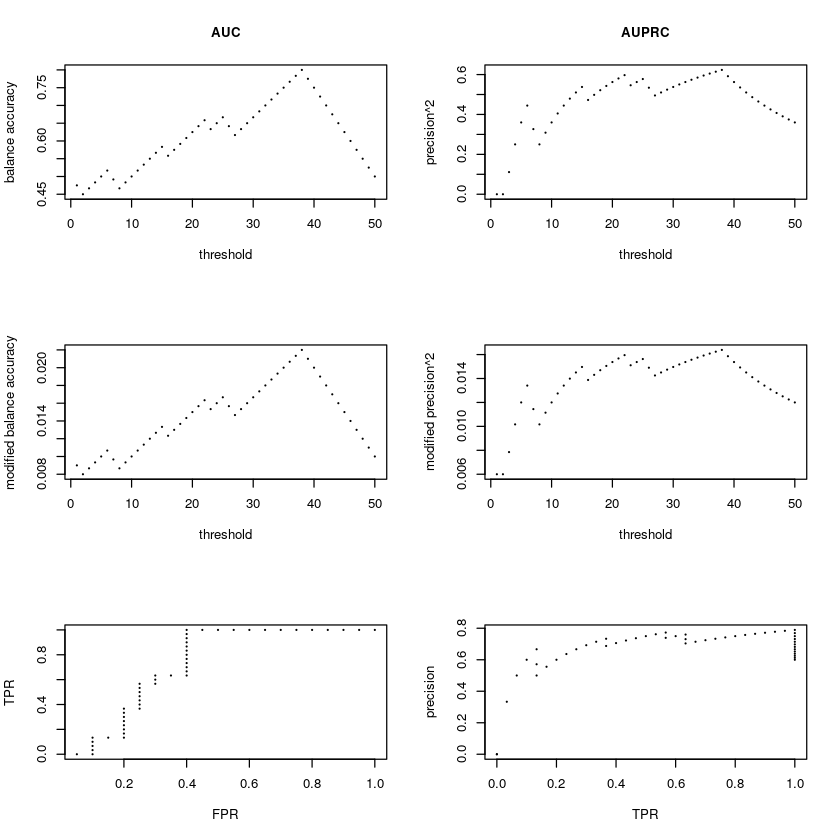

In [11]:
AUC_new <- append(AUC_new, new_AUC)
PRC_new <- append(PRC_new, new_AUPRC)
AUC_normal <- append(AUC_normal,  normal_AUC)
PRC_normal <- append(PRC_normal, normal_AUPRC)
AUC_formula <- append(AUC_formula,  formula_AUC)
delta_AUC <- append(delta_AUC, new_delta_AUC)


gaussian(20,30,0,5,4,2)
formula_gaussian_AUC(0,5,4,2)
frame(class0, class1)
calculate_vals(store_vals)

In [12]:
AUC_new <- append(AUC_new, new_AUC)
PRC_new <- append(PRC_new, new_AUPRC)
AUC_normal <- append(AUC_normal,  normal_AUC)
PRC_normal <- append(PRC_normal, normal_AUPRC)
AUC_formula <- append(AUC_formula,  formula_AUC)
delta_AUC <- append(delta_AUC, new_delta_AUC)

In [20]:
main <- function(sampleSize0, sampleSize1, m0, s0, m1, s1){
  distr <- gaussian(sampleSize0, sampleSize1, m0, s0, m1, s1)
  format <- frame(distr[,1], distr[,2])
  
  #class 1, class 0 distribution curves 
  a <- floor(format[length(format[,1]), 1])
  b <- ceiling(format[1,1])
  n <- 500
  upper <- max(max(hist(as.vector(distr[,1]), breaks=n)$counts), max(hist(as.vector(distr[,2]), breaks=n)$counts))
    hist(as.vector(distr[,1]), col='#619CFF',border='#619CFF',xlab='Score',main='',ylab='Frequency', breaks=n, xlim=c(a,b ), ylim=c(0,upper + 1 ))
    par(new=TRUE)
    hist(as.vector(distr[,2]), xlab='Score',ylab='Frequency',col='#00BA38',main='',border='#00BA38', breaks=n, xlim=c(a, b), ylim=c(0,upper + 1))
  
  closedFormula <- formula_gaussian_AUC(m0, s1, m1, s1)
  valuesImportant <- calculate_vals(format)
  
  
  
  return(c(valuesImportant, closedFormula))
}

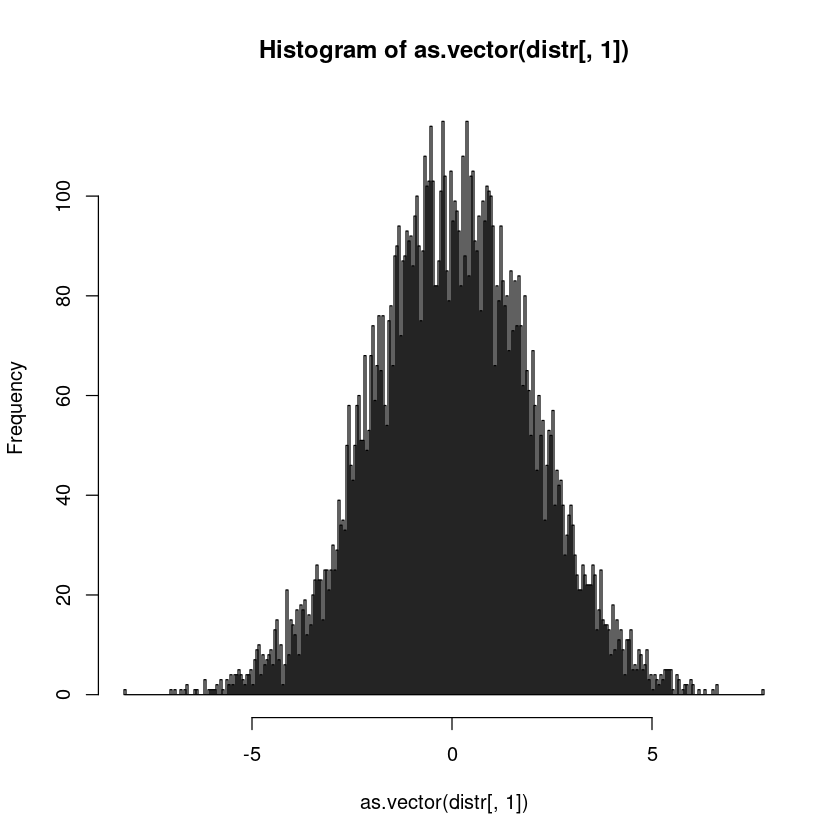

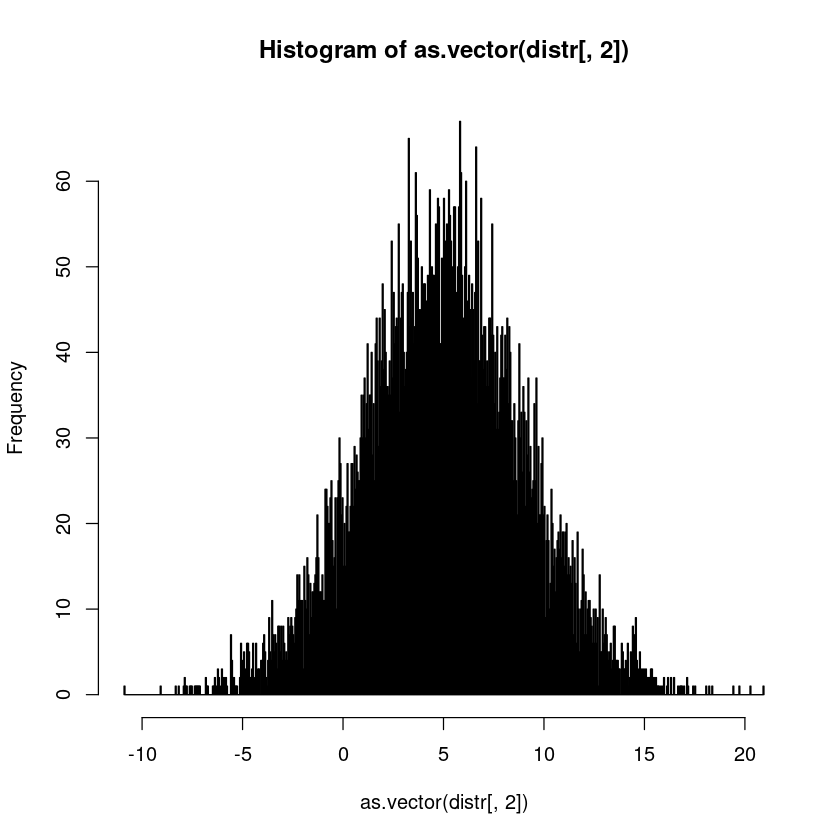

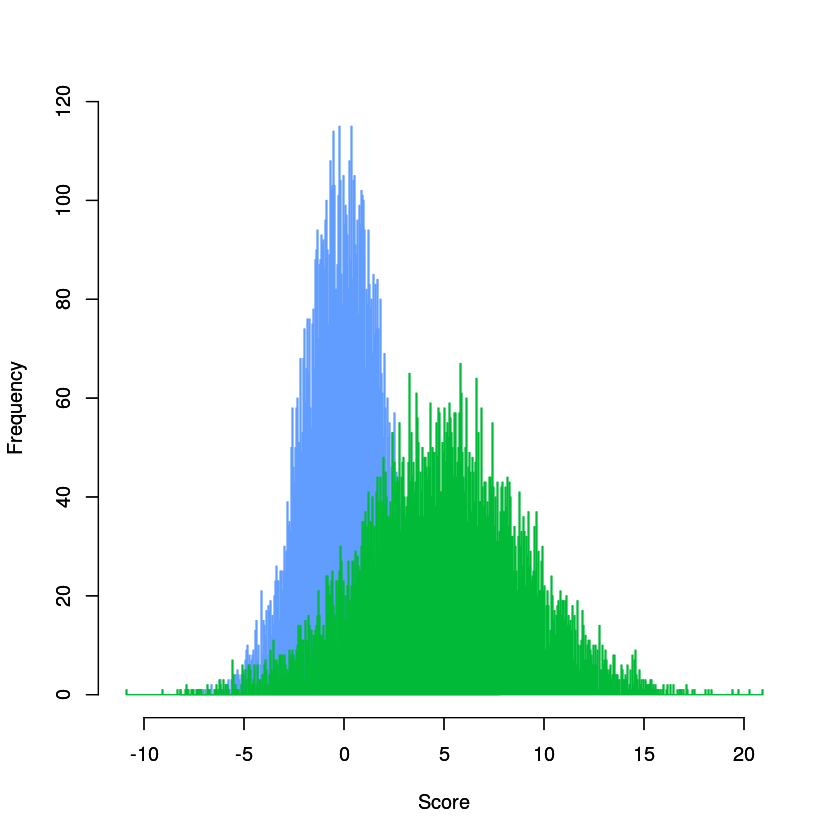

[1] 0.8670 0.8116

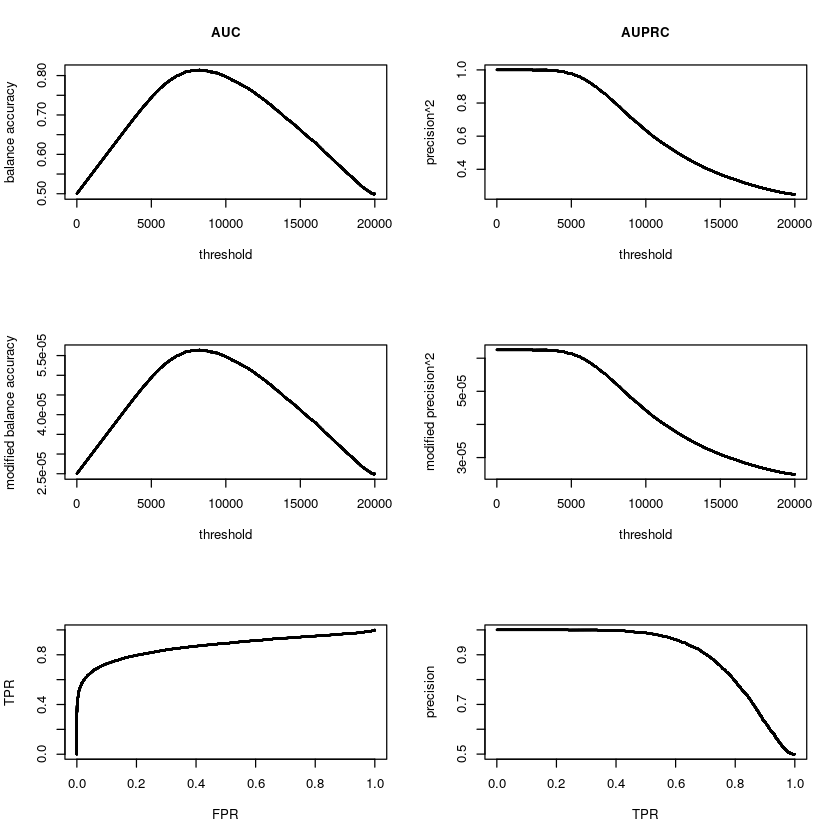

In [21]:
#normal_AUC, normal_AUPRC, new_AUC, new_delta_AURC, new_AUPRC, + closedFormula AUC
main(10000, 10000, 0, 2, 5, 4)

In [22]:
main_t <- function(sampleSize0, sampleSize1, m0, s0, m1, s1, extra1, extra2){
  distr <- triangle(sampleSize0, sampleSize1, m0, s0, m1, s1, extra1, extra2)
  format <- frame(distr[,1], distr[,2])
  
  #class 1, class 0 distribution curves 
  a <- floor(format[length(format[,1]), 1])
  b <- ceiling(format[1,1])
  n <- 500
  upper <- max(max(hist(as.vector(distr[,1]), breaks=n)$counts), max(hist(as.vector(distr[,2]), breaks=n)$counts))
    hist(as.vector(distr[,1]), col='#619CFF',border='#619CFF',xlab='Score',main='',ylab='Frequency', breaks=n, xlim=c(a,b ), ylim=c(0,upper + 1 ))
    par(new=TRUE)
    hist(as.vector(distr[,2]), xlab='Score',ylab='Frequency',col='#00BA38',main='',border='#00BA38', breaks=n, xlim=c(a, b), ylim=c(0,upper + 1))
  
  valuesImportant <- calculate_vals(format)
  
  
  
  return(valuesImportant)
}

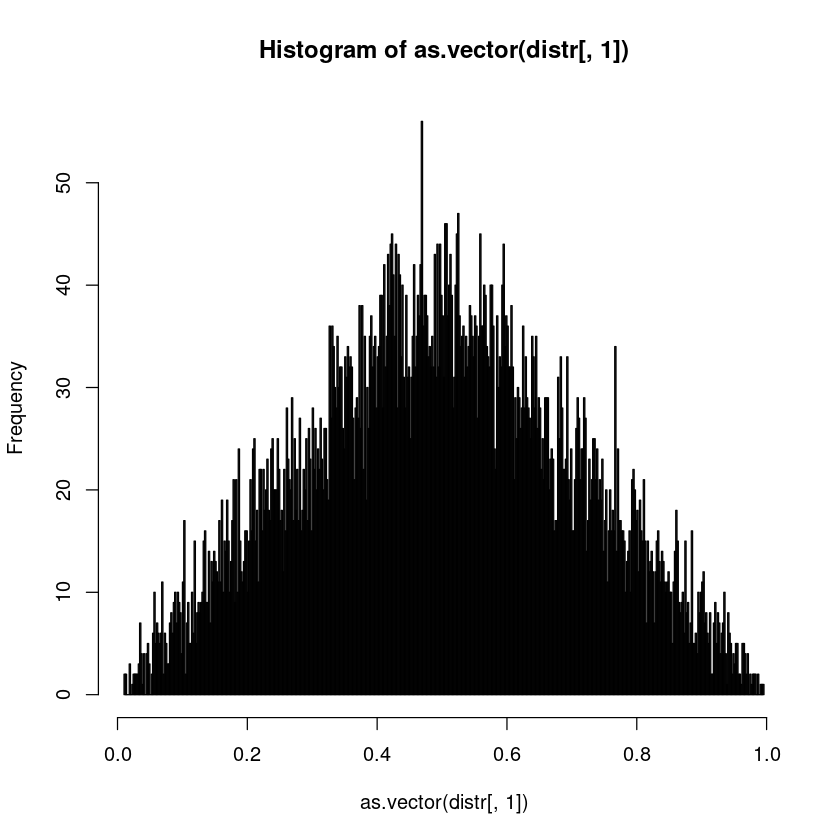

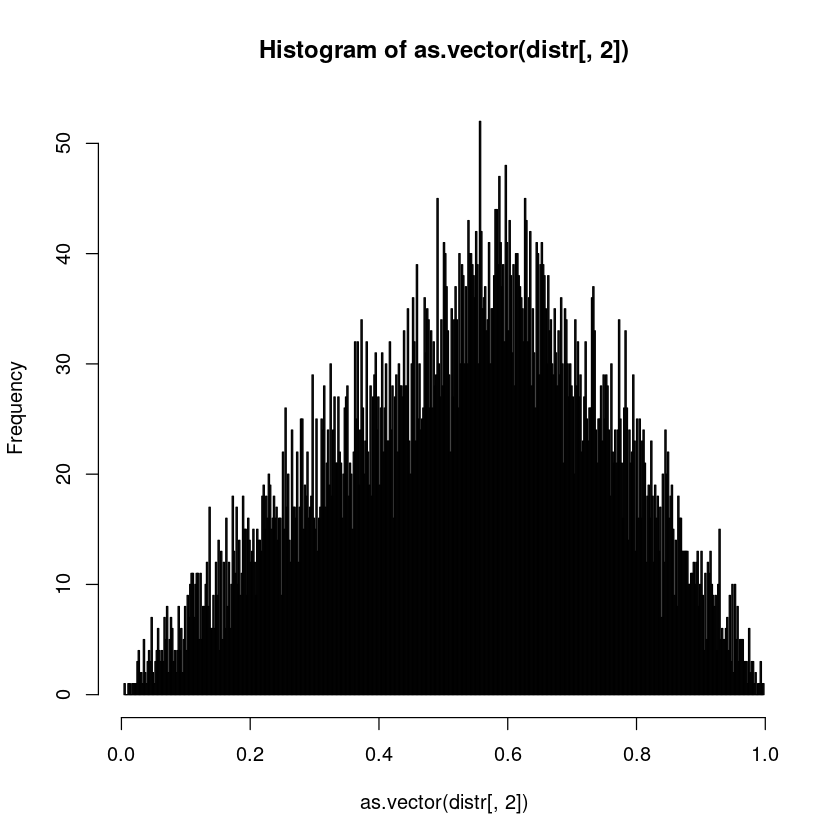

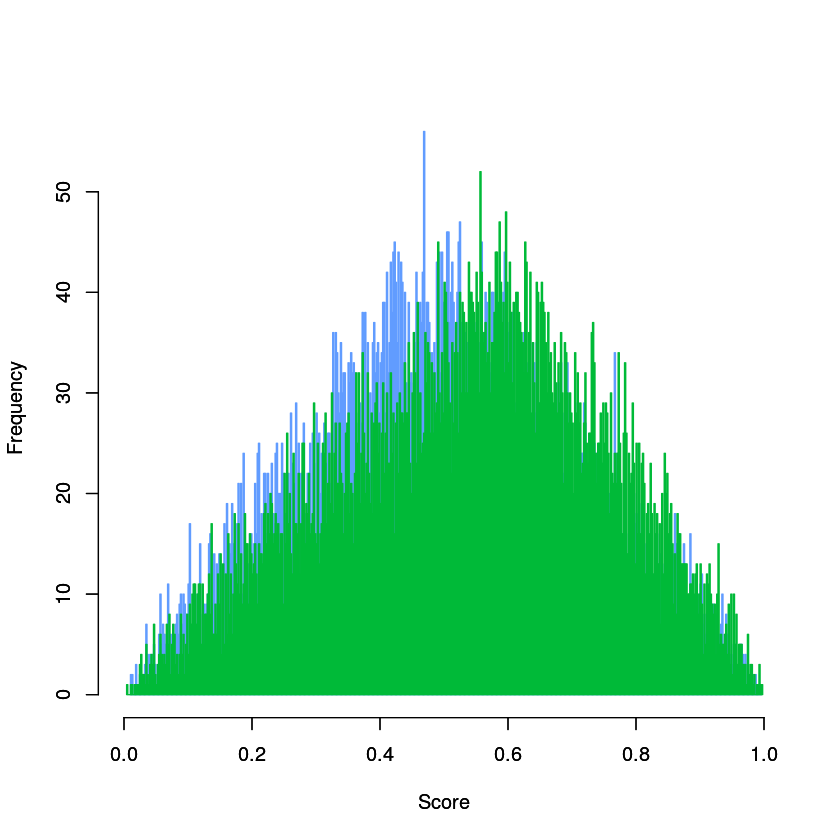

[1] 0.5579

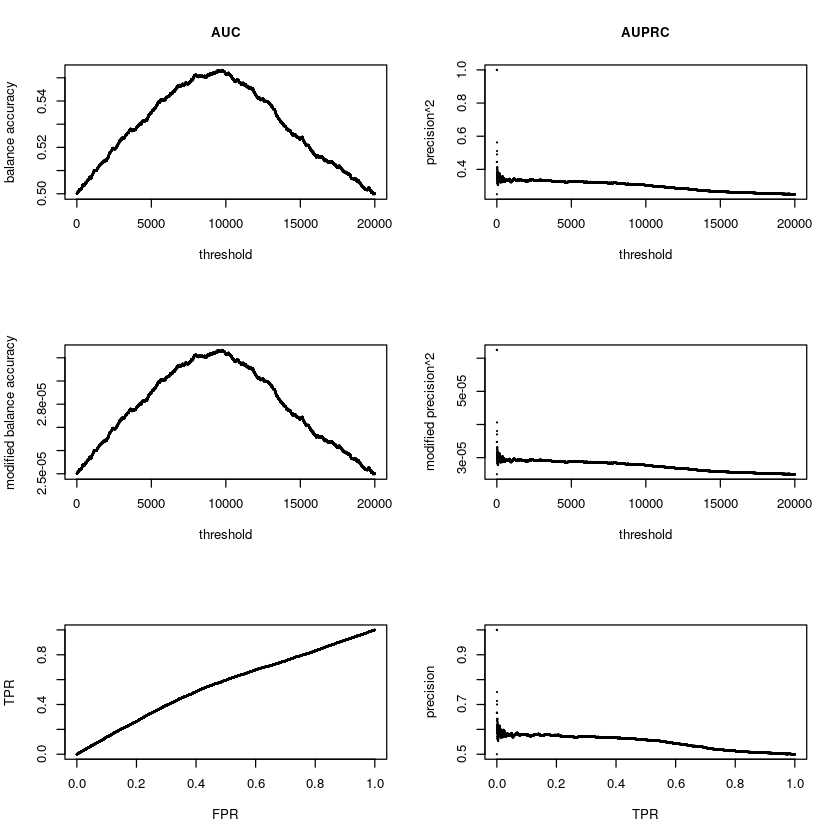

In [23]:
main_t(10000,10000,0,1,0.5,0,1,0.6)

In [24]:
main_u <- function(sampleSize0, sampleSize1, m0, s0, m1, s1){
  distr <- uniform(sampleSize0, sampleSize1, m0, s0, m1, s1)
  format <- frame(distr[,1], distr[,2])
  
  #class 1, class 0 distribution curves 
  a <- floor(format[length(format[,1]), 1])
  b <- ceiling(format[1,1])
  n <- 500
  upper <- max(max(hist(as.vector(distr[,1]), breaks=n)$counts), max(hist(as.vector(distr[,2]), breaks=n)$counts))
    hist(as.vector(distr[,1]), col='#619CFF',border='#619CFF',xlab='Score',main='',ylab='Frequency', breaks=n, xlim=c(a,b ), ylim=c(0,upper + 1 ))
    par(new=TRUE)
    hist(as.vector(distr[,2]), xlab='Score',ylab='Frequency',col='#00BA38',main='',border='#00BA38', breaks=n, xlim=c(a, b), ylim=c(0,upper + 1))
  
  valuesImportant <- calculate_vals(format)
  
  
  
  return(valuesImportant)
}

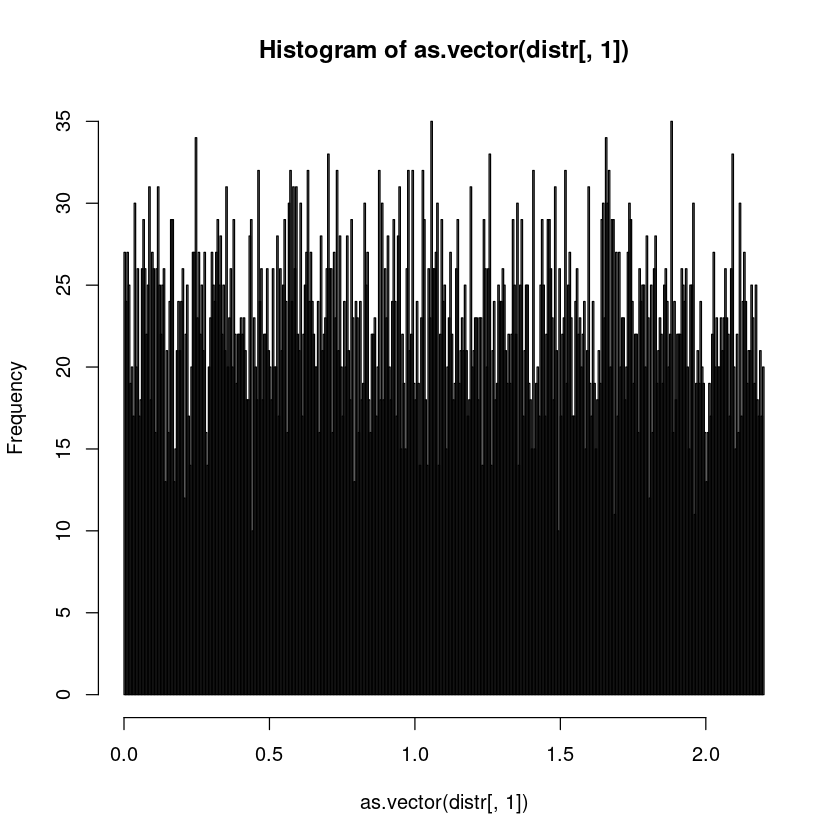

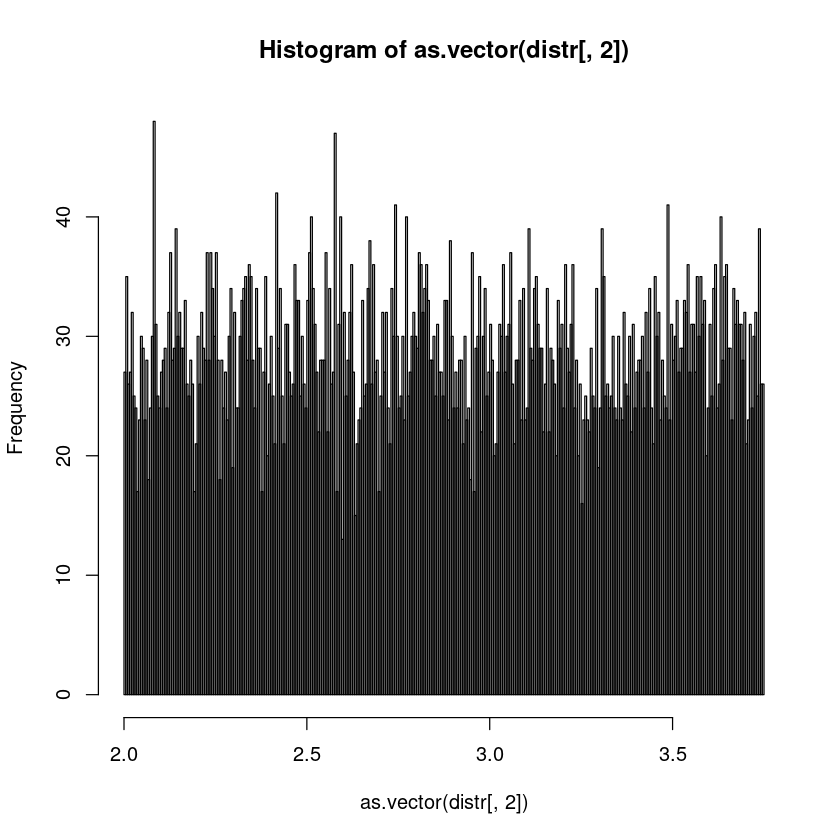

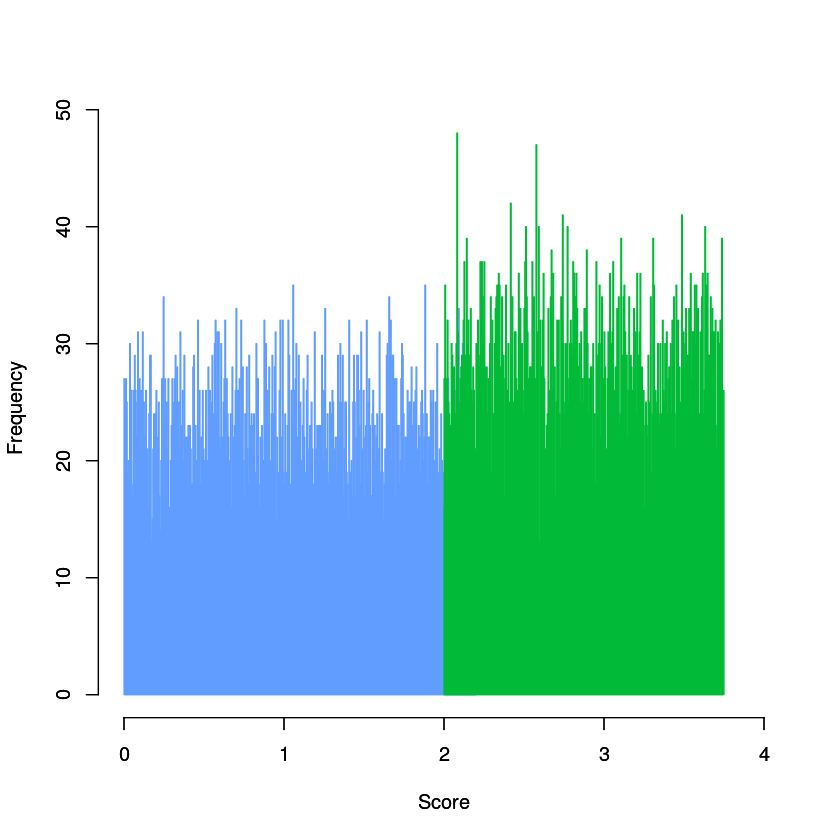

[1] 0.9952

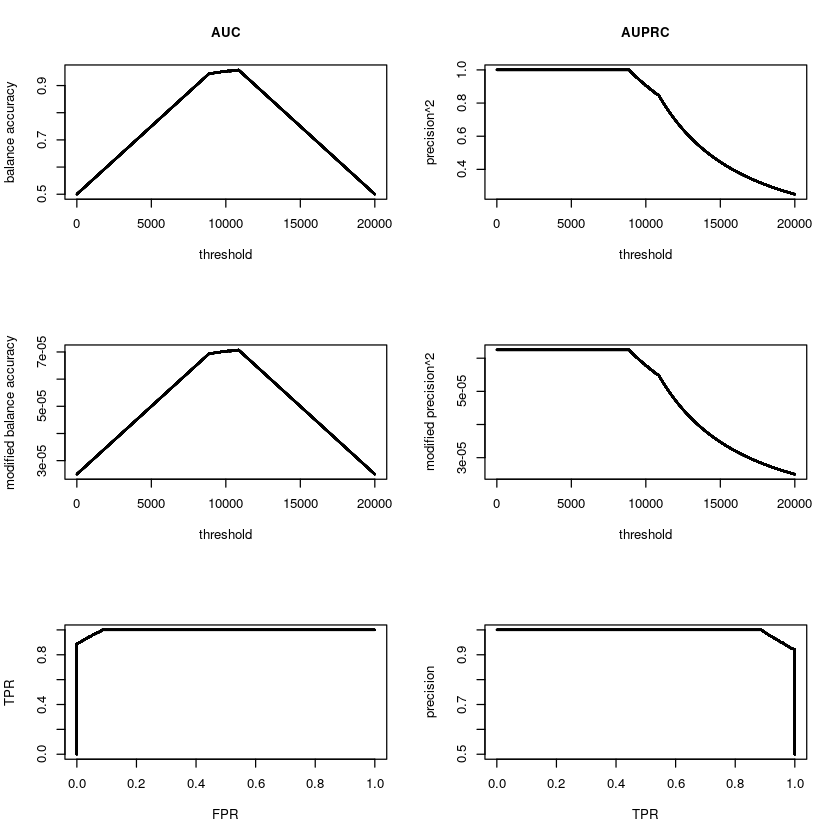

In [25]:
main_u(10000,10000,0,2.2,2,3.75)

In [26]:
calculate_vals <- function(store_vals){

    precision <- NULL
    tp_rate <- NULL
    fp_rate <- NULL
    bac <- NULL

    for (k in 1:length(store_vals$score)){
      sub <- store_vals[1:k,]
      fp <- length(sub$class[sub$class==0])
      tp <- length(sub$class[sub$class==1])
      tn <- length(store_vals$class[store_vals$class==0]) - length(sub$class[sub$class==0])

      prec <- tp / k
      tpr <- tp / length(store_vals$class[store_vals$class==1])
      fpr <- fp / length(store_vals$class[store_vals$class==0])
      spec <- tn / length(store_vals$class[store_vals$class==0])

      precision <- append(precision, prec)
      tp_rate <- append(tp_rate, tpr)
      fp_rate <- append(fp_rate, fpr)

      balance <- (tpr + spec)/2
      bac <- append(bac, balance)

    }

    len <- c(1:length(bac))
    par(mfrow=c(2,2))


    normal_AUC <- trapz(fp_rate, tp_rate)
    normal_AUPRC <- trapz(tp_rate, precision)

    new_AUC <- ((2/length(store_vals$class))*(sum(bac))) - (1/2)

    rho <- length(store_vals$class[store_vals$class==1]) / length(store_vals$class)
    new_AUPRC <- ((0.5*rho)*(1 + ((sum(precision^2)) / length(store_vals$class))/(rho^2)))

    return(c(normal_AUC,  normal_AUPRC, new_AUC, new_AUPRC))

}

In [27]:
gaussian <- function(samples0, samples1, mu0, sigma0, mu1, sigma1) {
   class0 <- rnorm(samples0, mu0, sigma0) 
   class1 <- rnorm(samples1, mu1, sigma1)
   test <- list()
   test$class0 <- class0
   test$class1 <- class1
   return(test)
   
}

In [28]:
main <- function(sampleSize0, sampleSize1, m0, s0, m1, s1){
  distr <- gaussian(sampleSize0, sampleSize1, m0, s0, m1, s1)
  format <- frame(distr$class0, distr$class1)
  valuesImportant <- calculate_vals(format)
  
  return(valuesImportant)
}

In [29]:
datasetSize <- seq(10, 50000, 500)
auc11<- NULL
auc21<- NULL
auc31<- NULL
prc11<- NULL
prc21<- NULL
prc31<- NULL
prc12<- NULL
prc13<- NULL
auc13<- NULL
auc12<- NULL

trr <- function(value){
  return(round(value, 0))
}

for (t in 1:length(datasetSize)){
  
  x <- round(datasetSize[t], 0)
  t11 <- main(trr(x/2), trr(x/2), 1.3,1,3,1)
  auc11 <- append(auc11, abs(t11[1] - t11[3]))
  prc11 <- append(prc11, abs(t11[2] - t11[4]))
  t21 <- main(trr(x*(2/3)), trr(x*(1/3)),1.3,1,3,1 )
  auc21 <- append(auc21, abs(t21[1] - t21[3]))
  prc21 <- append(prc21, abs(t21[2] - t21[4]))
  t31 <- main(trr(x*(3/4)), trr(x*(1/4)),1.3,1,3,1 )
  auc31 <- append(auc31, abs(t31[1] - t31[3]))
  prc31 <- append(prc31, abs(t31[2] - t31[4]))
  t12 <- main(trr(x*(1/3)), trr(x*(2/3)),1.3,1,3,1 )
  auc12 <- append(auc12, abs(t12[1] - t12[3]))
  prc12 <- append(prc12, abs(t12[2] - t12[4]))
  t13 <- main(trr(x*(1/4)), trr(x*(3/4)),1.3,1,3,1 )
  auc13 <- append(auc13, abs(t13[1] - t13[3]))
  prc13 <- append(prc13, abs(t13[2] - t13[4]))
  
  print(t/length(datasetSize))
}